In [1]:
import torch

if torch.cuda.is_available():
    device = 0   # GPU index
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("No GPU detected, running on CPU")


GPU: NVIDIA GeForce RTX 3060


In [2]:
import os, random, shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO


In [3]:
dataset_path = r"H:\Jupyter Notebook\ODS_New"
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")

print("Dataset Path:", dataset_path)


Dataset Path: H:\Jupyter Notebook\ODS_New


In [4]:
all_images = [f for f in os.listdir(images_path) if f.endswith(('.jpg','.jpeg','.png'))]

random.shuffle(all_images)
n_total = len(all_images)
n_train = int(0.7 * n_total)
n_val = int(0.2 * n_total)

train_files = all_images[:n_train]
val_files = all_images[n_train:n_train+n_val]
test_files = all_images[n_train+n_val:]

def move_files(files, split):
    for img_file in files:
        src_img = os.path.join(images_path, img_file)
        dst_img = os.path.join(images_path, split, img_file)
        os.makedirs(os.path.dirname(dst_img), exist_ok=True)
        shutil.copy(src_img, dst_img)

        label_file = img_file.rsplit('.', 1)[0] + ".txt"
        src_lbl = os.path.join(labels_path, label_file)
        dst_lbl = os.path.join(labels_path, split, label_file)
        os.makedirs(os.path.dirname(dst_lbl), exist_ok=True)
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, dst_lbl)

move_files(train_files, "train")
move_files(val_files, "valid")
move_files(test_files, "test")

print(f"Split complete: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")


Split complete: 12128 train, 3465 val, 1733 test


In [5]:
yaml_path = os.path.join(dataset_path, "data.yaml")
print("data.yaml ready:", yaml_path)


data.yaml ready: H:\Jupyter Notebook\ODS_New\data.yaml


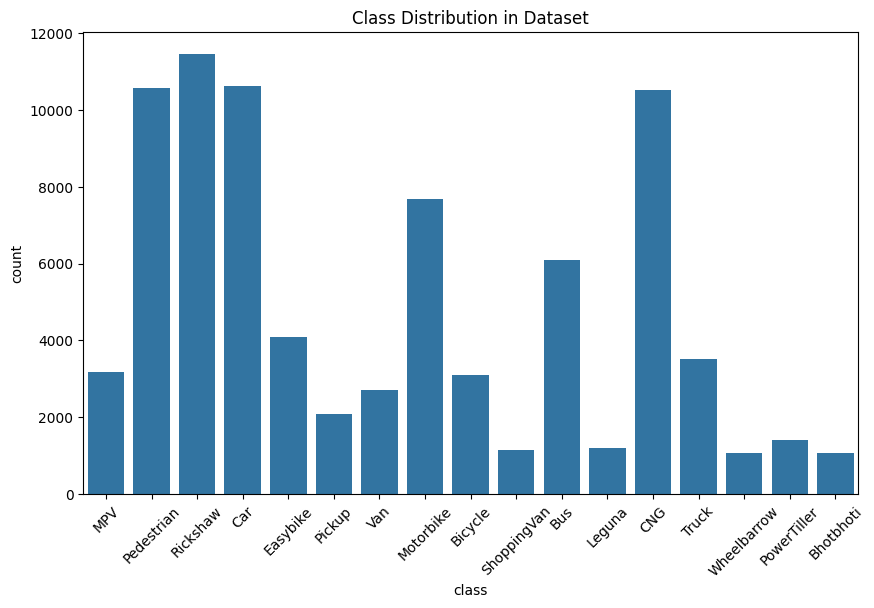

In [6]:
class_counts = {}
for split in ["train","valid","test"]:
    split_path = os.path.join(labels_path, split)
    if not os.path.exists(split_path):
        continue
    for file in os.listdir(split_path):
        with open(os.path.join(split_path, file)) as f:
            for line in f:
                cls = int(line.split()[0])
                class_counts[cls] = class_counts.get(cls, 0) + 1

# Load class names
with open(os.path.join(dataset_path, "Classes.txt")) as f:
    class_names = [line.strip() for line in f.readlines()]

counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
counts['class'] = [class_names[i] for i in counts.index]

plt.figure(figsize=(10,6))
sns.barplot(x="class", y="count", data=counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in Dataset")
plt.show()


In [ ]:
baseline_model = YOLO("yolov8n.pt")

baseline_model.train(
    data=yaml_path,
    epochs=5,          # small chunks
    imgsz=320,         
    batch=2,           # lighter load
    workers=0,         
    cache=False,
    device=device,
    name="baseline_vehicle",
    plots=False,       # disable plots
    verbose=False      # less console spam
)

baseline_results = baseline_model.val(data=yaml_path, device=device, plots=False, verbose=False)


Ultralytics 8.3.199  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=H:\Jupyter Notebook\ODS_New\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_vehicle, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

In [8]:
total = sum(class_counts.values())
class_weights = {cls: total/count for cls, count in class_counts.items()}
weights_list = [class_weights[i] for i in range(len(class_names))]

print("Class Weights:", dict(zip(class_names, weights_list)))


Class Weights: {'Bicycle': 26.354880413703942, 'Bus': 13.382898408009192, 'Bhotbhoti': 75.71216341689879, 'Car': 7.680324008665348, 'CNG': 7.74672240167205, 'Easybike': 19.961321909424726, 'Leguna': 68.40771812080537, 'Motorbike': 10.607779367763756, 'MPV': 25.666351904312243, 'Pedestrian': 7.706454966449296, 'Pickup': 38.996652319464374, 'PowerTiller': 57.872249822569195, 'Rickshaw': 7.115978706693428, 'ShoppingVan': 70.90608695652173, 'Truck': 23.19169510807736, 'Van': 30.022827687776143, 'Wheelbarrow': 76.06529850746269}


In [ ]:
btaa_model = YOLO("yolov8n.pt")

btaa_model.train(
    data=yaml_path,
    epochs=5,
    imgsz=320,
    batch=2,
    workers=0,
    cache=False,
    device=device,
    name="btaa_vehicle",
    plots=False,
    verbose=False
)

btaa_results = btaa_model.val(data=yaml_path, device=device, plots=False, verbose=False)


Ultralytics 8.3.199  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=H:\Jupyter Notebook\ODS_New\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=btaa_vehicle3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [12]:
import pandas as pd

baseline_results = pd.read_csv("runs/detect/baseline_vehicle/results.csv")
btaa_results = pd.read_csv("runs/detect/btaa_vehicle/results.csv")

print("Baseline Results:\n", baseline_results.tail(1))  # last epoch
print("BTAA Results:\n", btaa_results.tail(1))


Baseline Results:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
4      5  1664.72         1.32497         1.62318         1.12597   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
4               0.59762            0.49969           0.54145   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
4              0.34472       1.22123       1.34988       1.05748  0.000149   

     lr/pg1    lr/pg2  
4  0.000149  0.000149  
BTAA Results:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
4      5  1646.94         1.33123         1.61561         1.12247   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
4               0.56335            0.54798           0.54375   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
4              0.35409       1.19722       1.32349       1.03358  0.000149   

     lr/pg1    lr/pg2  
4  0.000149  0.000149  


In [15]:
with open("runs/detect/baseline_vehicle/results.csv") as f:
    print(f.read())


epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
1,352.434,1.54201,2.94393,1.20183,0.32546,0.40019,0.31359,0.18463,1.38023,2.37089,1.11232,0.000237881,0.000237881,0.000237881
2,681.762,1.48597,2.13661,1.18501,0.46457,0.41181,0.38004,0.23682,1.331,1.90573,1.09127,0.000381656,0.000381656,0.000381656
3,1002.06,1.4416,1.93296,1.18049,0.5438,0.48462,0.48245,0.29888,1.30761,1.61023,1.09533,0.000431184,0.000431184,0.000431184
4,1324.23,1.37914,1.7494,1.14677,0.59576,0.46523,0.4962,0.32071,1.25964,1.49703,1.06839,0.000289884,0.000289884,0.000289884
5,1664.72,1.32497,1.62318,1.12597,0.59762,0.49969,0.54145,0.34472,1.22123,1.34988,1.05748,0.000148512,0.000148512,0.000148512

